# Time-related feature engineering

Vamos a presentar diferentes estrategias para aprovechar las características relacionadas con el tiempo para una tarea de regresión de la demanda de bicicletas compartidas que depende en gran medida de los ciclos comerciales (días, semanas, meses) y ciclos anuales de temporada.

Primero, nos traemos los datos de la demanda bicicletas compartidas desde fetch_openml y los cargamos en un dataset

In [1]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame

Echemos un vistazo los datos que contiene el dataset. Tenemos datos del tiempo y la demanda de bicicletas por dia y hora:

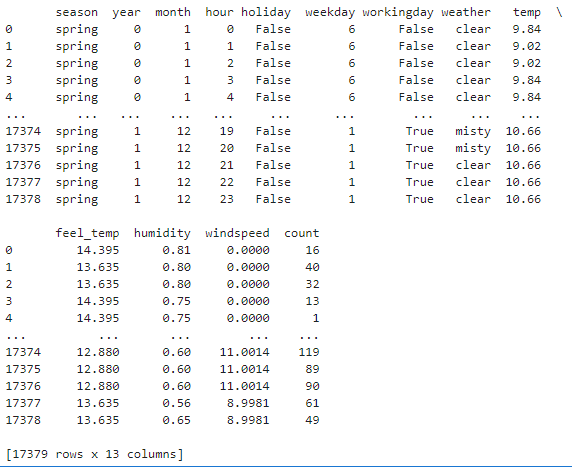

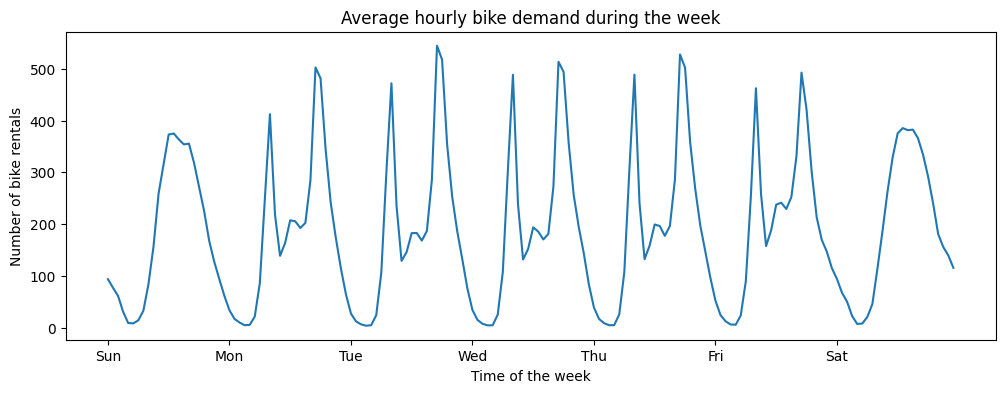

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
#media de horas de demanda por dia
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
#creamos la figura y los ejes y configuramos algunos detalles de la gráfica
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)


El objetivo del problema de predicción es el recuento absoluto de alquileres de bicicletas sobre cada hora:

In [3]:
df["count"].max()

977

Reescalemos la variable objetivo (número de bicicletas de alquiler por hora) para predecir una demanda relativa, de modo que el error medio absoluto se interprete más fácilmente como una fracción de la demanda máxima.:

In [4]:
y = df["count"] / df["count"].max()

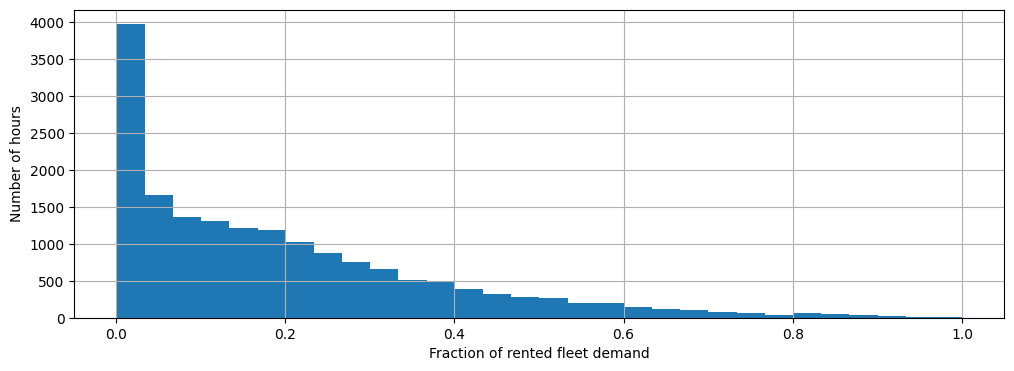

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))
# trazamos un histograma de los datos en la serie.
y.hist(bins=30, ax=ax)    #dividimos el histograma en 30 contenedores,los datos se agruparán en 30 intervalos y se contará cuántos puntos de datos caen en cada intervalo.
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

In [6]:
#guardo en una variable todos los datos del dataframe excepto la columna 'count' que la eliminamos del dataframe
X = df.drop("count", axis="columns")
# conteo de los valores únicos en la columna "weather" del DataFrame. 
X["weather"].value_counts()

weather
clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: count, dtype: int64

Vamos a limpiar un poco los datos. Ya que sólo hay 3 eventos "heavy_rain", no podemos utilizar esta categoría para entrenar modelos de aprendizaje automático con validación cruzada.  
En su lugar, simplificamos la representación agrupándolos en la categoría "lluvia".

In [7]:
X["weather"] = (
    X["weather"]
    .astype(object)
    .replace(to_replace="heavy_rain", value="rain")
    .astype("category")
)

X["weather"].value_counts()

weather
clear    11413
misty     4544
rain      1422
Name: count, dtype: int64

Observamos los datos de las estaciones del año y vemos que en este caso logicamente no es necesario limpiar datos

In [8]:
X["season"].value_counts()

season
fall      4496
summer    4409
spring    4242
winter    4232
Name: count, dtype: int64

   
### Validación cruzada basada en el tiempo

*La validación cruzada es una técnica comúnmente utilizada para evaluar el rendimiento de un modelo y estimar cómo se generalizará a datos no vistos. En la validación cruzada k-fold, el conjunto de datos se divide en k partes iguales (pliegues), y el modelo se entrena k veces, cada vez utilizando k-1 pliegues como datos de entrenamiento y el pliegue restante como conjunto de validación. Luego se promedian los resultados de todas las iteraciones para obtener una estimación final del rendimiento del modelo.*

Dado que el conjunto de datos es un registro de eventos ordenados en el tiempo (demanda horaria), utilizaremos un divisor de validación cruzada sensible al tiempo para evaluar nuestro modelo de previsión de la demanda de la forma más realista posible.  
Utilizamos un intervalo de 2 días entre el lado de entrenamiento y el de prueba de las divisiones.   
También limitamos el tamaño del conjunto de entrenamiento para que el rendimiento de los pliegues de validación cruzada sea más estable (restringir la cantidad de datos utilizados para entrenar un modelo durante la validación cruzada). Esto se hace típicamente cuando se trabaja con conjuntos de datos grandes y se quiere mejorar la estabilidad del rendimiento del modelo durante la validación cruzada

1000 puntos de datos de prueba deberían ser suficientes para cuantificar el rendimiento del modelo. Esto representa algo menos de un mes y medio de datos de prueba contiguos:

In [9]:
# TimeSeriesSplit es el Validador cruzado de series temporales.
    # Proporciona índices de entrenamiento/prueba para dividir muestras de datos de series temporales
    # que se observan a intervalos de tiempo fijos, en conjuntos de entrenamiento/prueba.
    # En cada división, los índices de prueba deben ser superiores a los anteriores
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

Inspeccionemos manualmente las distintas divisiones para comprobar que la función `TimeSeriesSplit` funciona como esperamos

In [10]:
all_splits = list(ts_cv.split(X, y))   # el método split de ts_cv divide los datos en conjuntos de entrenamiento y prueba, 
                                       # proporcionando índices (o máscaras) para ambos. 
                                       # Toma dos argumentos: X, que son las características o variables independientes, y 
                                       # y, que son las etiquetas o la variable dependiente.
train_0, test_0 = all_splits[0]     
X.iloc[test_0]
X.iloc[train_0]

train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
6331,winter,0,9,9,False,1,True,misty,26.24,28.790,0.89,12.9980
6332,winter,0,9,10,False,1,True,misty,26.24,28.790,0.89,12.9980
6333,winter,0,9,11,False,1,True,clear,27.88,31.820,0.79,15.0013
6334,winter,0,9,12,False,1,True,misty,27.88,31.820,0.79,11.0014
6335,winter,0,9,13,False,1,True,misty,28.70,33.335,0.74,11.0014
...,...,...,...,...,...,...,...,...,...,...,...,...
16326,winter,1,11,0,False,0,False,misty,12.30,15.150,0.70,11.0014
16327,winter,1,11,1,False,0,False,clear,12.30,14.395,0.70,12.9980
16328,winter,1,11,2,False,0,False,clear,11.48,14.395,0.81,7.0015
16329,winter,1,11,3,False,0,False,misty,12.30,15.150,0.81,11.0014


Ya hemos terminado con la parte de limpiar y comprobar los datos. Ahora vamos a crear algunos modelos predictivos:

### Gradient Boosting
*La regresión de aumento gradual con árboles de decisión suele ser lo suficientemente flexible como para manejar con eficacia datos tabulares heterogéneos con una mezcla de características categóricas y numéricas, siempre que el número de muestras sea lo suficientemente grande. Aquí, utilizamos la moderna :class:`~sklearn.ensemble.HistGradientBoostingRegressor` con soporte nativo para características categóricas. Por lo tanto, sólo tenemos que establecer `categorical_features="from_dtype"` para que las características con dtype categórico se consideren características categóricas. Como referencia, extraemos las características categóricas del marco de datos basándonos en el dtype. Los árboles internos utilizan una regla una regla de división de árboles específica para estas características.*
      
Las variables numéricas no necesitan preprocesamiento, sólo probamos los hiperparámetros por defecto para este modelo:

In [11]:
from sklearn.compose import ColumnTransformer                      # para aplicar transformaciones diferentes a diferentes columnas de los datos
from sklearn.ensemble import HistGradientBoostingRegressor         # implementa un regresor de aumento de gradiente basado en histogramas, útil para conjuntos de datos grandes y con muchas características
from sklearn.model_selection import cross_validate                 # para realizar validación cruzada de modelos
from sklearn.pipeline import make_pipeline                         # para crear un pipeline de procesamiento de datos y modelado de manera más conveniente. Un pipeline es una secuencia de transformaciones de datos seguida de un modelo.


# configuro un regresor de aumento de gradiente basado en histogramas (HistGradientBoostingRegressor) y extraigo las columnas categóricas del DataFrame X
gbrt = HistGradientBoostingRegressor(categorical_features="from_dtype", random_state=42)
categorical_columns = X.columns[X.dtypes == "category"]
print("Categorical features:", categorical_columns.tolist())

Categorical features: ['season', 'holiday', 'workingday', 'weather']


Evaluemos nuestro modelo de Gradient Boosting con el error absoluto medio de la demanda relativa promediada a través de nuestras 5 divisiones de validación cruzada basadas en el tiempo:

In [12]:
import numpy as np


# evalua un modelo de regresión utilizando validación cruzada
def evaluate(model, X, y, cv, model_prop=None, model_step=None):                # cv: Es el esquema de validación cruzada que se utilizará para dividir los datos.
    cv_results = cross_validate(                                                # model_prop: Es una cadena que especifica la propiedad del modelo que se desea imprimir y evaluar.
        model,                                                                  # model_step: Especifica el paso dentro del pipeline del modelo para acceder al estimador en caso de que el modelo sea un pipeline.
        X,                                                                      # La función cross_validate de scikit-learn se utiliza para realizar la validación cruzada y calcular las métricas de evaluación especificadas.
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]    # imprimir y evaluar una propiedad específica del modelo
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")                          # se calcula el valor de esa propiedad para cada estimador obtenido en cada división de validación cruzada y se imprime el promedio de estos valores.          
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"             # se calculan y se imprimen las métricas de evaluación, que incluyen el error absoluto medio (MAE)
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"             # y el error cuadrático medio (RMSE) a lo largo de todas las divisiones de validación cruzada
    )


evaluate(gbrt, X, y, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 100.0
Mean Absolute Error:     0.044 +/- 0.003
Root Mean Squared Error: 0.068 +/- 0.005


TO BE C